# Data extraction and transformation for the Pará, State in Brazil


This notebook is part of the project "New Schools Location in Brazil" and it is focused on the data extraction and transformation for the Pará State in Brazil.


## Step 0. Import libraries and setup environment


In [1]:
# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
import os

## Libraries installed with urbanpy ##
## pip install urbanpy==0.2.2-dev0 ##
import urbanpy as up

# Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer

# Geospatial Libraries
import geopandas as gpd
import osmnx as ox
from shapely.geometry.point import Point


# Progress Bar
from tqdm.auto import tqdm

## Other Libraries commonly used for maps ##
import contextily as cx  # Add basemaps
from matplotlib_scalebar.scalebar import ScaleBar

import geobr

In [3]:
tqdm.pandas()

In [4]:
# Set parameters for basemaps
from secret import *

BASEMAP = cx.providers.MapBox(
    id="mapbox/satellite-v9",
    accessToken=MAPBOX_API_KEY,
)

BASEMAP_WITH_LABELS = cx.providers.MapBox(
    id="mapbox/satellite-streets-v12",
    accessToken=MAPBOX_API_KEY,
)

BASEMAP_WHITE = cx.providers.MapBox(
    id="mapbox/light-v10",
    accessToken=MAPBOX_API_KEY,
)

BASEMAP_DARK = cx.providers.MapBox(
    id="mapbox/dark-v10",
    accessToken=MAPBOX_API_KEY,
)

## Step 1. Define Area of Interest (AoI)


For this, we will:

- Download a administrative limits for Brazil, and get the multi-level admistrative limits of Pará usig the geoBR library.
- Read schools data downloaded using the R package CensoBr.


In [5]:
os.mkdir("outputs") if not os.path.exists("outputs") else None
if os.path.exists("outputs/brazil_state.geojson"):
    brazil = gpd.read_file("outputs/brazil_state.geojson")
else:
    brazil = geobr.read_country(year=2020, simplified=True, verbose=True)
    brazil.to_file("outputs/brazil_state.geojson", driver="GeoJSON")

In [6]:
brazil.head()

,code_state,abbrev_state,name_state,code_region,name_region,geometry
0,11.0,RO,Rondônia,1.0,Norte,"MULTIPOLYGON (((-65.38150 -10.42907, -65.37916..."
1,12.0,AC,Acre,1.0,Norte,"MULTIPOLYGON (((-71.07772 -9.82774, -71.08554 ..."
2,13.0,AM,Amazônas,1.0,Norte,"MULTIPOLYGON (((-69.83766 -3.68659, -69.71230 ..."
3,14.0,RR,Roraima,1.0,Norte,"MULTIPOLYGON (((-63.96008 2.47313, -63.96041 2..."
4,15.0,PA,Pará,1.0,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42843 ..."


In [7]:
# Area of Interest (AoI)
brazil_geom = brazil.geometry.unary_union

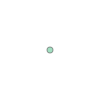

In [11]:
brazil_geom

In [14]:
# Set parameters for scalebar
point1 = brazil_geom.centroid  # Para's center
point2 = Point(point1.x + 1, point1.y)  # One full degree of longitude (X) apart
points = gpd.GeoDataFrame(geometry=[point1, point2], crs=brazil.crs)
points_utm = ox.project_gdf(points)  # Projected - meters
dist_meters = points.geometry.iloc[0].distance(
    points.geometry.iloc[1]
)  # Distance - meters

## Step 2. Extract and process Census Sociodemographic geographical data


### Step 2.1. Extracting Census Tracts Data from IBGE

Census Tract's Geometries are obtained in this notebook with the `GeoBR` Python library


In [16]:
if os.path.exists("outputs/br_census_tracts.parquet"):
    br_cntr = gpd.to_parquet("outputs/br_census_tracts.parquet")
else:
    br_cntr = geobr.read_census_tract(code_tract="all", year=2010)
    br_cntr.to_parquet("outputs/br_census_tracts.parquet")

In [17]:
print("Number of census tracts in BR:", len(br_cntr))

Number of census tracts in BR: 316545


In [18]:
br_cntr.head()

,code_tract,zone,code_muni,name_muni,name_neighborhood,code_neighborhood,code_subdistrict,name_subdistrict,code_district,name_district,code_state,geometry
0,110009812000003,RURAL,1100098.0,Espigão D'oeste,None,NaN,1.100098e+10,None,110009812.0,Novo Paraíso,11.0,"MULTIPOLYGON (((-60.89575 -11.35508, -60.89557..."
1,110009815000001,URBANO,1100098.0,Espigão D'oeste,None,NaN,1.100098e+10,None,110009815.0,Flor Da Serra,11.0,"MULTIPOLYGON (((-60.74999 -11.39990, -60.74575..."
2,110009815000002,RURAL,1100098.0,Espigão D'oeste,None,NaN,1.100098e+10,None,110009815.0,Flor Da Serra,11.0,"MULTIPOLYGON (((-60.72986 -11.35738, -60.72954..."
3,110009815000003,RURAL,1100098.0,Espigão D'oeste,None,NaN,1.100098e+10,None,110009815.0,Flor Da Serra,11.0,"MULTIPOLYGON (((-60.91829 -11.29374, -60.91600..."
4,110009815000004,RURAL,1100098.0,Espigão D'oeste,None,NaN,1.100098e+10,None,110009815.0,Flor Da Serra,11.0,"MULTIPOLYGON (((-60.69047 -11.38391, -60.68743..."


Now, we will read a [dataset generated with the `CensoBR` R package here](link-to-r-notebook). In this dataset we have census variables such as Income and Population by Age that are useful to identify areas where schools are needed.


In [19]:
censobr_tract_income = pd.read_csv("data/censobr_tract_income.csv", index_col=0)

In [20]:
print("Number of census tracts obtainer in R for Brazil:", len(censobr_tract_income))

Number of census tracts obtainer in R for Brazil: 308993


In [21]:
censobr_tract_income.head()

,code_tract,V002,V003,pessoa01_V021,pessoa01_V022,pessoa01_V023,pessoa01_V024,pessoa01_V025,pessoa01_V026,pessoa01_V027,...,pessoa01_V044,pessoa01_V045,pessoa01_V046,pessoa01_V047,pessoa01_V048,pessoa01_V049,pessoa01_V050,pessoa01_V051,pessoa01_V052,income_pc
1,521520705000006,164,92958.0,1.0,4.0,0.0,4.0,3.0,6.0,1.0,...,1.0,2.0,4.0,2.0,0.0,2.0,4.0,2.0,2.0,566.817073
2,521520705000007,221,112781.0,3.0,3.0,4.0,4.0,4.0,2.0,2.0,...,6.0,3.0,3.0,3.0,1.0,4.0,3.0,3.0,1.0,510.321267
3,521520705000008,290,126647.0,3.0,8.0,1.0,7.0,1.0,1.0,4.0,...,2.0,8.0,4.0,8.0,1.0,4.0,2.0,2.0,3.0,436.713793
4,521520705000009,150,90031.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,...,2.0,1.0,2.0,1.0,1.0,2.0,3.0,1.0,2.0,600.206667
5,521520705000010,192,134946.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,...,2.0,5.0,5.0,2.0,3.0,3.0,1.0,3.0,1.0,702.843750


In [22]:
# Verify code_tract values have the same type in both datasets
print("Type of code_tract in para_cntr:", br_cntr.code_tract.dtype)
print(
    "Type of code_tract in censobr_tract_income:", censobr_tract_income.code_tract.dtype
)

Type of code_tract in para_cntr: object
Type of code_tract in censobr_tract_income: int64


In [23]:
br_cntr["code_tract"] = br_cntr["code_tract"].astype("int64")

In [24]:
print(
    "Number of census tracts with associated data:",
    censobr_tract_income["code_tract"].isin(br_cntr["code_tract"].unique()).sum(),
)

Number of census tracts with associated data: 308968


In [25]:
# Merge datasets to visualize census data in maps
para_cntr_income = br_cntr.merge(
    censobr_tract_income, left_on="code_tract", right_on="code_tract", how="left"
)

In [ ]:
39 = 5 years old
40 = 6 years old
41 = 7 years old
42 = 8 years old
43 = 9 years old



In [28]:
para_cntr_income["pessoa01_V053"]

KeyError: 'pessoa01_V053'

In [26]:
list(range(39, 44))

[39, 40, 41, 42, 43]

In [30]:
# Between 5 and 9 years old
cols_fundamental_ai = [f"pessoa01_V{i:03d}" for i in range(39, 44)]
para_cntr_income["bra_t_5_2010"] = para_cntr_income[cols_fundamental_ai].sum(axis=1)
# Between 10 and 14 years old
cols_fundamental_af = [f"pessoa01_V{i:03d}" for i in range(44, 49)]
para_cntr_income["bra_t_10_2010"] = para_cntr_income[cols_fundamental_af].sum(axis=1)
# Between 15 and 18!! years old
# WARNING: We dont have for 19 years old (I can run this again to get it)
cols_medio = [f"pessoa01_V{i:03d}" for i in range(49, 53)]
para_cntr_income["bra_t_15_2010"] = para_cntr_income[cols_medio].sum(axis=1)

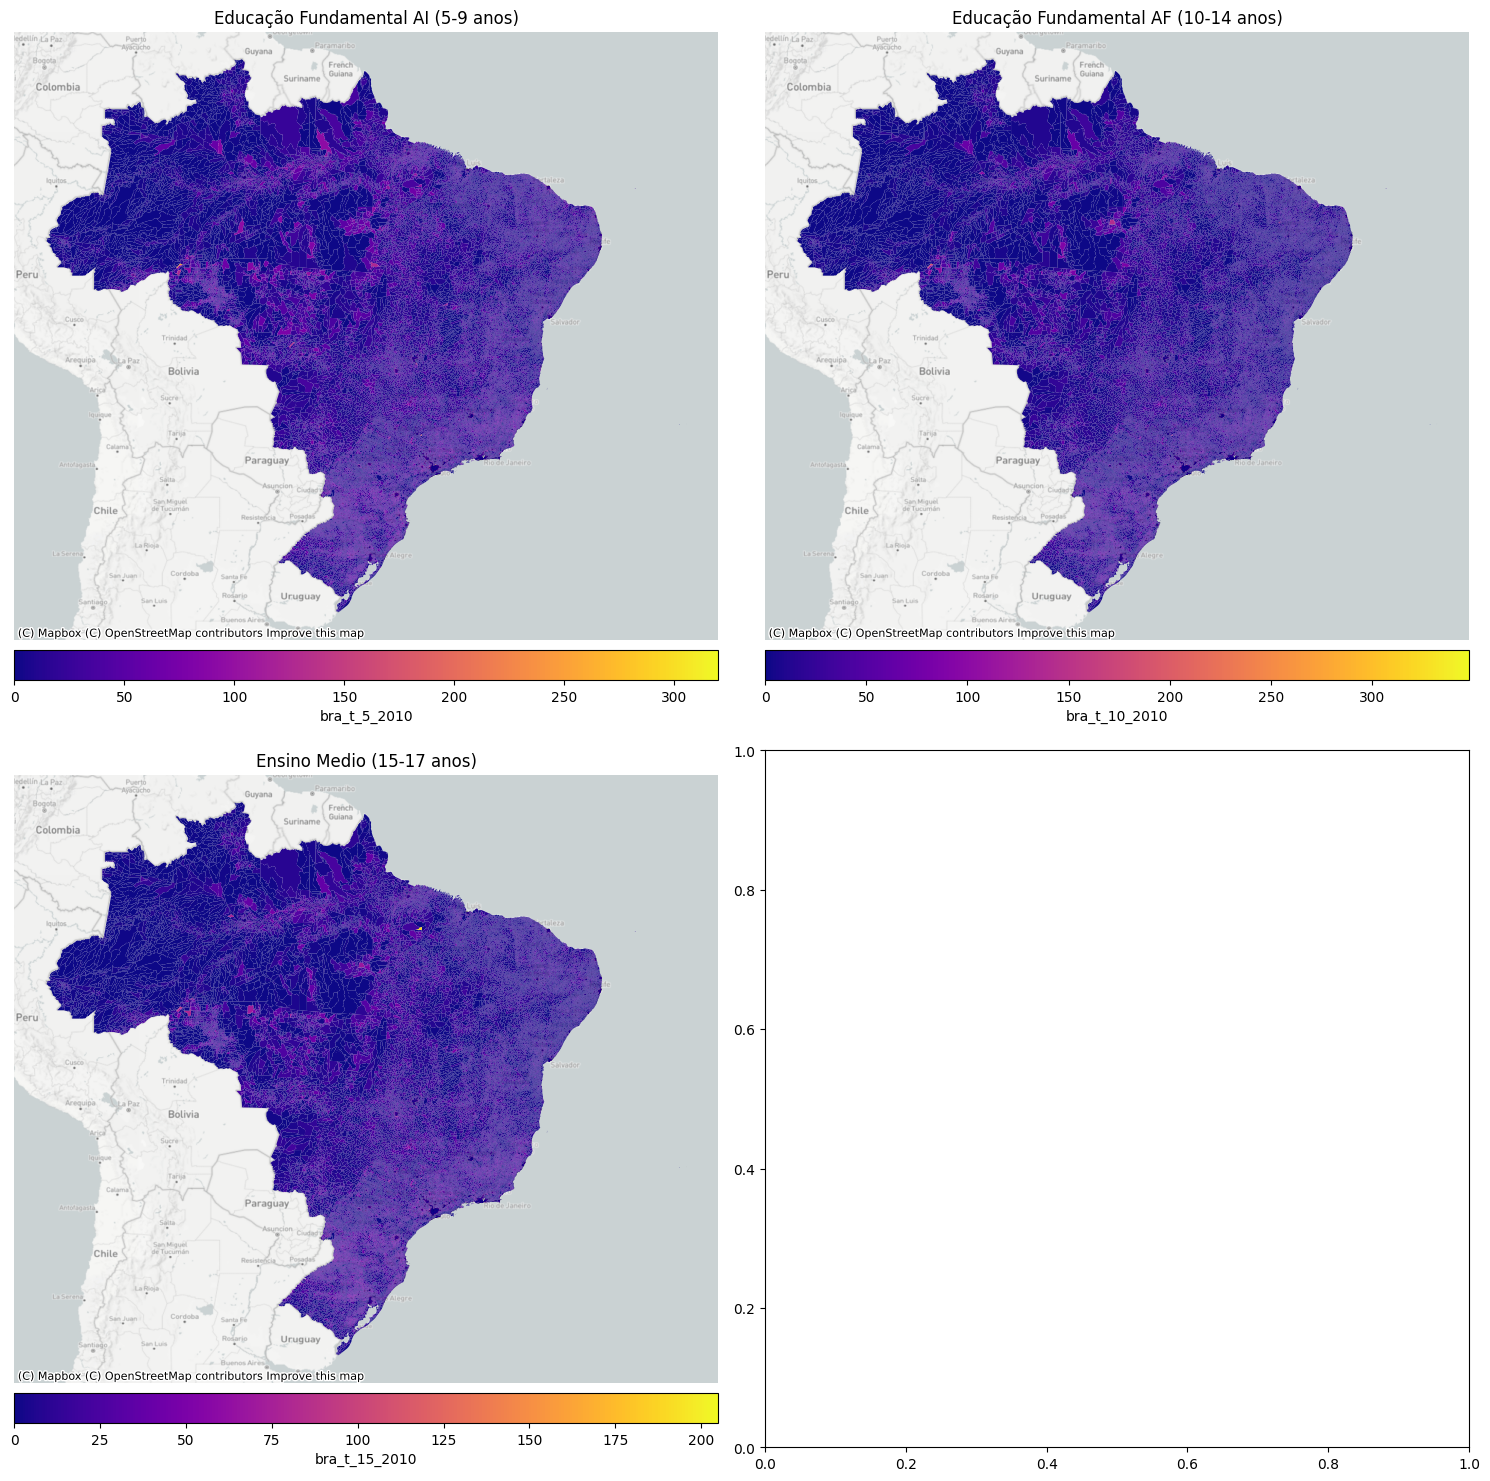

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

cols = ["bra_t_5_2010", "bra_t_10_2010", "bra_t_15_2010"]
titles = [
    "Educação Fundamental AI (5-9 anos)",
    "Educação Fundamental AF (10-14 anos)",
    "Ensino Medio (15-17 anos)",
]

for ax, col, title in zip(axes.flatten(), cols, titles):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    para_cntr_income.plot(
        ax=ax,
        column=col,
        cmap="plasma",
        legend=True,
        legend_kwds={"label": col, "orientation": "horizontal"},
        missing_kwds={"color": "lightgrey"},
        cax=cax,
    )
    ax.set_title(title)
    ax.set_axis_off()
    cx.add_basemap(ax, crs=brazil.crs.to_string(), source=BASEMAP_WHITE)

plt.tight_layout()

# plt.savefig(
#     "outputs/maps/para/06-para_state_pop_by_edulevel.png", dpi=300, bbox_inches="tight"
# )

### Step 2.2. Download Meta's High Resolution Population Density


Let's see all the available datasets for Brazil in Humanitarian Data Exchange (HDX).


In [33]:
brazil_hdx_datasets = up.download.search_hdx_dataset("brazil")
brazil_hdx_datasets

,created,name,population,size_mb,url
id,,,,,
0,2019-06-11,BRA_children_under_five_2019-06-01_csv.zip,Children (ages 0-5),159.14,https://data.humdata.org/dataset/c17003d1-47f4...
1,2019-06-11,BRA_elderly_60_plus_2019-06-01_csv.zip,Elderly (ages 60+),159.42,https://data.humdata.org/dataset/c17003d1-47f4...
2,2019-06-11,BRA_men_2019-06-01_csv.zip,Men,160.20,https://data.humdata.org/dataset/c17003d1-47f4...
26,2019-06-11,BRA_women_2019-06-01_csv.zip,Women,160.21,https://data.humdata.org/dataset/c17003d1-47f4...
27,2019-06-11,BRA_women_of_reproductive_age_15_49_2019-06-01...,Women of reproductive age (ages 15-49),160.03,https://data.humdata.org/dataset/c17003d1-47f4...
28,2019-06-11,BRA_youth_15_24_2019-06-01_csv.zip,Youth (ages 15-24),159.79,https://data.humdata.org/dataset/c17003d1-47f4...
33,2019-06-25,population_bra_northeast_2018-10-01.csv..zip,Overall population density,71.24,https://data.humdata.org/dataset/c17003d1-47f4...
34,2019-06-25,population_bra_northwest_2018-10-01.csv.zip,Overall population density,13.46,https://data.humdata.org/dataset/c17003d1-47f4...
35,2019-06-25,population_bra_southeast_2018-10-01.csv.zip,Overall population density,159.42,https://data.humdata.org/dataset/c17003d1-47f4...


We will download the **Overall population density** dataset from HDX. This dataset contains the population density of Brazil at 30m2 resolution.


In [34]:
pop_type = "Overall population density"  # This could be specified depending on the census population age group

In [35]:
%%time
if os.path.exists("outputs/pop_general_brazil.parquet"):
    pop_general_brazil = gpd.read_parquet("outputs/pop_general_brazil.parquet")
else:
    pop_general_brazil = up.download.get_hdx_dataset(
        resources_df=brazil_hdx_datasets,
        ids=brazil_hdx_datasets.query("population == @pop_type").index.tolist(),
    )
    pop_general_brazil.to_parquet("outputs/pop_general_brazil.parquet")

CPU times: user 15.4 s, sys: 3.24 s, total: 18.6 s
Wall time: 1min 11s


The obtained dataset is simple and contains the following columns:


In [42]:
pop_general_brazil = gpd.GeoDataFrame(
    pop_general_brazil,
    geometry=gpd.points_from_xy(
        pop_general_brazil.longitude, pop_general_brazil.latitude
    ),
    crs="EPSG:4326",
)

In [43]:
pop_general_brazil.to_parquet("outputs/pop_general_brazil.parquet")

In [44]:
print("Number population data points for BR:", len(pop_general_brazil))

Number population data points for BR: 36666346


### Step 2.3. Aggregate Population Density in Hexagons (Uniform Spatial Units)


In [39]:
if os.path.exists("outputs/br_hexs.parquet"):
    br_hexs = gpd.read_parquet("outputs/br_hexs.parquet")
else:
    br_hexs = up.geom.gen_hexagons(resolution=7, city=brazil)
    br_hexs.to_parquet("outputs/br_hexs.parquet")

In [45]:
type(br_hexs), type(pop_general_brazil)

(geopandas.geodataframe.GeoDataFrame, geopandas.geodataframe.GeoDataFrame)

In [46]:
%%time
br_hexs_pop = up.geom.merge_shape_hex(
    hexs=br_hexs,
    shape=pop_general_brazil,
    agg={
        "population_2020": "sum",
    },
)

CPU times: user 31.2 s, sys: 23.9 s, total: 55.1 s
Wall time: 1min 8s


In [47]:
# Check if there are duplicated hexagons
br_hexs_pop["hex"].duplicated().sum()

0

In [49]:
# Verify the integrity of the data size
br_hexs.shape, br_hexs_pop.shape

((1538660, 2), (1538660, 3))

### Step 2.4. Convert Census Tract Level Data to Hexagons Level

Census tract level numerical variables like population and income will be divided in hexagons proportionally to the Meta high-resolution population density.


In [50]:
# Verify crs are the same
br_hexs.crs.to_string(), para_cntr_income.crs.to_string()

('EPSG:4326', 'EPSG:4674')

In [51]:
# if not make them the same
para_cntr_income = para_cntr_income.to_crs(br_hexs.crs)

In [43]:
# # Population divided in hexagons proportionally to the area of the census tracts (not interesting for this case)
# pop_hexs_pops_census = up.geom.overlay_polygons_hexs(
#     polygons=para_cntr_income,
#     hexs=para_hexs_pop,
#     hex_col="hex",
#     columns=["pop_3_5_years", "pop_6_14_years", "pop_15_17_years", "pop_18_years", "V002", "V003"],
# )

# pop_hexs_pops_census.head()

In [44]:
def proportional_overlay():
    # TODO: Use the code below to implement this function
    pass

In [52]:
br_hexs_pop.head()

,hex,geometry,population_2020
0,878a22372ffffff,"POLYGON ((-63.23969 -9.68777, -63.24644 -9.698...",9.172924
1,878a202a4ffffff,"POLYGON ((-63.99138 -10.08643, -63.99823 -10.0...",22.183531
2,878b1bacdffffff,"POLYGON ((-62.52294 -11.47603, -62.52964 -11.4...",NaN
3,878b19522ffffff,"POLYGON ((-62.63370 -12.26016, -62.64044 -12.2...",NaN
4,878b1ba03ffffff,"POLYGON ((-62.47503 -11.64714, -62.48173 -11.6...",33.324752


In [53]:
%%time
# Overlay intersection (this operation is time expensive ~2min)
overlayed = gpd.overlay(para_cntr_income, br_hexs_pop, how="intersection")

CPU times: user 1min 41s, sys: 7.7 s, total: 1min 48s
Wall time: 1min 57s


In [54]:
para_cntr_income.shape, br_hexs_pop.shape, overlayed.shape

((316545, 50), (1538660, 3), (2709148, 52))

In [56]:
overlayed.head()

,code_tract,zone,code_muni,name_muni,name_neighborhood,code_neighborhood,code_subdistrict,name_subdistrict,code_district,name_district,...,pessoa01_V050,pessoa01_V051,pessoa01_V052,income_pc,bra_t_5_2010,bra_t_10_2010,bra_t_15_2010,hex,population_2020,geometry
0,110009812000003,RURAL,1100098.0,Espigão D'oeste,None,NaN,1.100098e+10,None,110009812.0,Novo Paraíso,...,3.0,6.0,2.0,417.576577,27.0,26.0,13.0,878a34c03ffffff,37.256593,"POLYGON ((-60.87803 -11.48496, -60.88230 -11.4..."
1,110009805000022,RURAL,1100098.0,Espigão D'oeste,None,NaN,1.100098e+10,None,110009805.0,Espigão D'oeste,...,6.0,8.0,9.0,209.632091,32.0,34.0,31.0,878a34c03ffffff,37.256593,"POLYGON ((-60.88655 -11.48041, -60.88507 -11.4..."
2,110009812000003,RURAL,1100098.0,Espigão D'oeste,None,NaN,1.100098e+10,None,110009812.0,Novo Paraíso,...,3.0,6.0,2.0,417.576577,27.0,26.0,13.0,878a34c18ffffff,15.238181,"POLYGON ((-60.85550 -11.43504, -60.85432 -11.4..."
3,110009815000002,RURAL,1100098.0,Espigão D'oeste,None,NaN,1.100098e+10,None,110009815.0,Flor Da Serra,...,5.0,5.0,4.0,213.118343,23.0,25.0,18.0,878a34c18ffffff,15.238181,"MULTIPOLYGON (((-60.84750 -11.44533, -60.84739..."
4,110009812000003,RURAL,1100098.0,Espigão D'oeste,None,NaN,1.100098e+10,None,110009812.0,Novo Paraíso,...,3.0,6.0,2.0,417.576577,27.0,26.0,13.0,878a34ce6ffffff,7.537381,"POLYGON ((-60.88007 -11.40089, -60.88220 -11.4..."


In [57]:
# Downscaling helper functions
def min_max(x):
    return (x - x.min()) / (x.max() - x.min())


def downscale_proportionally(x, cols, prop_col):
    scaled_proportion = (x[prop_col] - x[prop_col].min()) / (
        x[prop_col].max() - x[prop_col].min()
    )
    downscaled_values = []
    for col in cols:
        col_downscaled = x[col].unique()[0] * scaled_proportion
        col_downscaled.name = col + "_adj"
        downscaled_values.append(col_downscaled)

    return pd.concat(downscaled_values, axis=1)

In [58]:
# Columns to process
cols = ["bra_t_5_2010", "bra_t_10_2010", "bra_t_15_2010"]

In [60]:
# Downsample census variables using proportional to Meta's population densit
overlayed_scaled = overlayed.groupby("code_tract").progress_apply(
    downscale_proportionally,
    prop_col="population_2020",
    cols=cols,
)

  0%|          | 0/315094 [00:00<?, ?it/s]

In [61]:
overlayed.shape, overlayed_scaled.shape

((2709148, 52), (2709148, 3))

In [62]:
processed_cols = overlayed_scaled.columns.tolist()

In [63]:
overlayed_scaled_complete = overlayed.merge(
    overlayed_scaled.reset_index().drop("code_tract", axis=1),
    left_index=True,
    right_on="level_1",  # overlayed_index
    how="left",
)

In [64]:
overlayed_scaled_complete.shape, overlayed_scaled.shape

((2709148, 56), (2709148, 3))

In [65]:
overlayed_scaled_complete[processed_cols].isna().sum()

bra_t_5_2010_adj     1223370
bra_t_10_2010_adj    1223370
bra_t_15_2010_adj    1223370
dtype: int64

In [66]:
per_hexagon_data = overlayed_scaled_complete.groupby("hex")[processed_cols].sum()

In [67]:
br_hexs_pop.shape, per_hexagon_data.shape

((1538660, 3), (1538537, 3))

In [68]:
# Preserve data as GeoDataFrame
hex_df = br_hexs_pop.merge(per_hexagon_data, on="hex", how="left")

In [69]:
br_hexs_pop.shape, per_hexagon_data.shape, hex_df.shape

((1538660, 3), (1538537, 3), (1538660, 6))

In [70]:
br_hexs_pop["population_2020"].isna().sum()

854091

In [71]:
(br_hexs_pop["population_2020"] == 0).sum()

2418

In [72]:
hex_df[processed_cols + ["population_2020"]].isna().sum()

bra_t_5_2010_adj        123
bra_t_10_2010_adj       123
bra_t_15_2010_adj       123
population_2020      854091
dtype: int64

In [73]:
hex_gdf = gpd.GeoDataFrame(hex_df.copy(), crs=br_hexs_pop.crs)

In [74]:
# Conserve nan values
for col in processed_cols:
    nans_filter = hex_gdf[hex_gdf["population_2020"].isna() & (hex_gdf[col] == 0)].index
    hex_gdf.loc[nans_filter, col] = np.nan

In [75]:
hex_gdf[processed_cols + ["population_2020"]].isna().sum()

bra_t_5_2010_adj     854111
bra_t_10_2010_adj    854111
bra_t_15_2010_adj    854111
population_2020      854091
dtype: int64

Compare the total number of census tracts and hexagons in Pará


In [77]:
print("Census Tracts:", para_cntr_income.shape[0], "-->", "Hexagons:", hex_gdf.shape[0])

Census Tracts: 316545 --> Hexagons: 1538660


In [82]:
hex_gdf = hex_gdf.rename(
    {
        "bra_t_5_2010_adj": "bra_t_5_2010",
        "bra_t_10_2010_adj": "bra_t_10_2010",
        "bra_t_15_2010_adj": "bra_t_15_2010",
    },
    axis=1,
)

In [87]:
hex_gdf["pob_primaria"] = hex_gdf["bra_t_5_2010"]
hex_gdf["pob_secundaria"] = hex_gdf[["bra_t_10_2010", "bra_t_15_2010"]].sum(axis=1)
hex_gdf["country"] = "bra"

In [88]:
hex_gdf.to_parquet("outputs/br_pop_hex_7.parquet")

We will use the census track variable to determine the urban area of Pará.


In [105]:
urban_area = geobr.read_urban_area(year=2015)

In [106]:
para_urban_area = urban_area.clip(para_state.geometry.iloc[0])

In [107]:
para_urban_area = para_urban_area.to_crs(hex_gdf.crs)

In [108]:
para_urban_area_gdf = gpd.GeoDataFrame(
    geometry=[para_urban_area.unary_union], crs=para_urban_area.crs
)

In [109]:
# Generate hexagons using urban area as boundary
para_urban_area_hex = up.geom.gen_hexagons(resolution=8, city=para_urban_area_gdf)
para_urban_area_idx = para_urban_area_hex["hex"].unique().tolist()

In [110]:
# Create urban_area column in hex
hex_gdf["urban_area"] = 0
# Assign 1 to hexagons that area in the urban area
hex_gdf.loc[hex_gdf["hex"].isin(para_urban_area_idx), "urban_area"] = 1

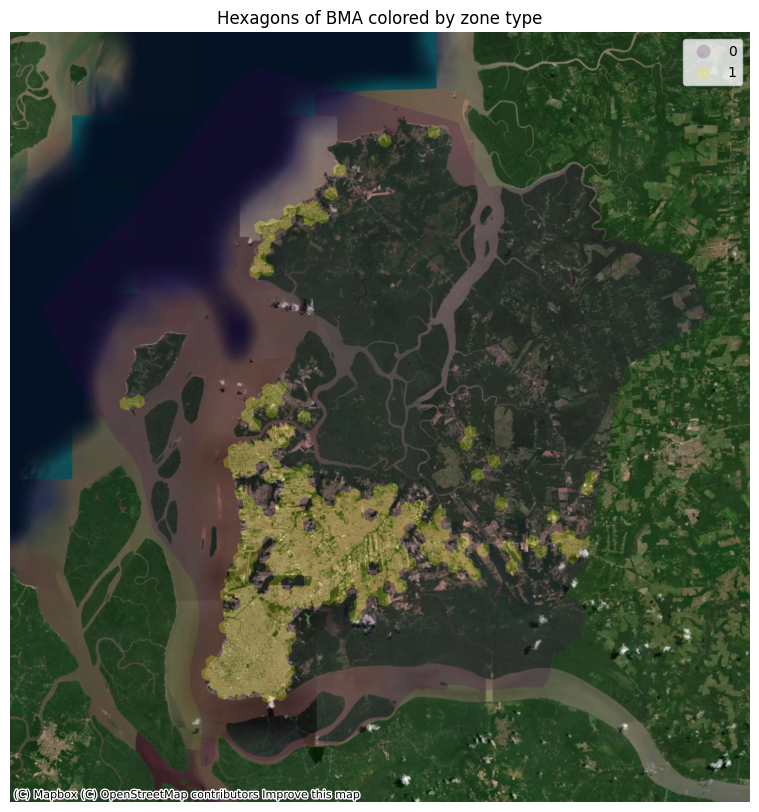

In [111]:
ax = hex_gdf.clip(belem_muni.unary_union).plot(
    "urban_area",
    legend=True,
    categorical=True,
    alpha=0.2,
    figsize=(10, 10),
    cmap="viridis",
)

# Set title and legend
ax.set_title("Hexagons of BMA colored by zone type")

# Add basemap
cx.add_basemap(ax, crs=para_state.crs.to_string(), source=BASEMAP)

# Remove axis
ax.set_axis_off()

plt.savefig("outputs/maps/para/10-para_hexagon_urban.png", dpi=300, bbox_inches="tight")

plt.show()

We can see that the urban areas are correctly identified. Considering the satellite image, we can see that the urban areas are the ones with more buildings and roads.


In [112]:
# Print the number of hexagons with population and school data
print(
    "Number of hexagons with population data:",
    hex_gdf[hex_gdf["population_2020"].notna()].shape[0],
    "\nNumber of hexagons with school data:",
    hex_gdf[hex_gdf["code_school"].notna()].shape[0],
    "\nNumber of hexagons with population or school data:",
    hex_gdf[hex_gdf["population_2020"].notna() | hex_gdf["code_school"].notna()].shape[
        0
    ],
)

Number of hexagons with population data: 131881 
Number of hexagons with school data: 6160 
Number of hexagons with population or school data: 132361


In [113]:
# Finally, we can save the hexagons as a parquet file
hex_gdf.to_parquet("outputs/23112023_para_hexs_final.parquet")

In [114]:
# Save the hexagons with population and school data
hex_gdf[hex_gdf["population_2020"].notna() | hex_gdf["code_school"].notna()].drop(
    "geometry", axis=1
).to_csv("outputs/29112023_para_hexs_final.csv")

In [115]:
# We can also export to other more human-readable formats but they are significantly slower & heavier

# hex_gdf.drop("geometry", axis=1).to_csv("outputs/23112023_para_hexs_final.csv")
# hex_gdf.to_file("outputs/23112023_para_hexs_final.geojson", driver="GeoJSON")

## Summary

We have extracted and processed schools and sociodemographic data from multiple source. The final results is a dataset on which each row is a H3 Hexagon. This will allow us to compare and analyze different microregions in Para. The variables obtained are the the following:

| Source                   | Variable name                       | Type        | Description                                                                       |
| ------------------------ | ----------------------------------- | ----------- | --------------------------------------------------------------------------------- |
| Meta's HRSM              | population_2020                     | Numerical   | Total Population                                                                  |
| IBGE's Census\*          | pop_3_5_years_adj                   | Numerical   | Population between 3 months and 5 years old                                       |
| IBGE's Census\*          | pop_6_14_years_adj                  | Numerical   | Population between 6 and 14 years old                                             |
| IBGE's Census\*          | pop_15_17_years_adj                 | Numerical   | Population between 15 and 17 years old                                            |
| IBGE's Census\*          | pop_18_years_adj                    | Numerical   | Population between 18 years old                                                   |
| IBGE's Census\*          | V002_adj                            | Numerical   | Total Population                                                                  |
| IBGE's Census\*          | V003_adj                            | Numerical   | Income (R$)                                                                       |
| INEP's School Census     | ensino_fundamental                  | Numerical   | Ensino Fundamental Schools Count                                                  |
| INEP's School Census     | educacao_infantil                   | Numerical   | Educacao Infantil Schools Count                                                   |
| INEP's School Census     | ensino_medio                        | Numerical   | Ensino Medio Schools Count                                                        |
| INEP's School Census     | educacao_jovens_adultos             | Numerical   | Educacao Jovens Adultos Schools Count                                             |
| INEP's School Census     | educacao_profissional               | Numerical   | Educacao Profissional Schools Count                                               |
| INEP's School Census     | no_specified                        | Numerical   | Count of schools with unspecified type                                            |
| INEP's School Census     | publica                             | Numerical   | Public Schools Count                                                              |
| INEP's School Census     | privada                             | Numerical   | Private Schools Count                                                             |
| Custom School Census\*\* | Matriculas totales                  | Numerical   | Total Enrolled Students                                                           |
| Custom School Census\*\* | Matrículas oficiales                | Numerical   | Oficially Enrolled Students                                                       |
| Custom School Census\*\* | matric*total*[school type]          | Numerical   | Enrolled Students by School Type                                                  |
| Custom School Census\*\* | matric*oficial*[school type]        | Numerical   | Enrolled Students by School Type                                                  |
| Custom School Census\*\* | diff*pop_matric_total*[school type] | Numerical   | Difference between target student population and enrolled students by School Type |
| Custom School Census\*\* | rate*pop_matric_total*[school type] | Numerical   | Ratio between target student population and enrolled students by School Type      |
| IBGE's Urban Footprints  | urban_area                          | Categorical | 1=Urban or 0=Rural                                                                |
| Ours                     | income_pc                           | Numerical   | Income Per Capita (R$)                                                            |

\* IBGE's Census: Variables where downscaled proportionally to Meta's high resolution population data.  
\*\* Custom School Census: This dataset was provided by IDB Education team in Brazil (need to ask for the source)
